# H1N1 Vaccines

Kendall McNeil, October 2023

# 1. Project Description & Objective

DESCRIPTION: Beginning in the spring of 2009, the H1N1 influenza virus, commonly referred to as "swine flu," swept across the globe. In fact, at my own high school, we had the first case of swine flu in the entire state of Texas and were shut down for over a month. It is estimated that in the first year, swine flu was responsible for  363,000 deaths worldwide. 

OBJECTIVE: The objective of this project is to identify individuals who will not receive a swine flu vaccine. Predicting individuals who will not receive the vaccine will help to inform the CDC’s marketing strategies. To do this, I have analyzed over 26,000 data points collected via phone call through the National 2009 H1N1 Flu Survey. This survey was administered by the National Center for Health Statistics in collaboration with the CDC. 


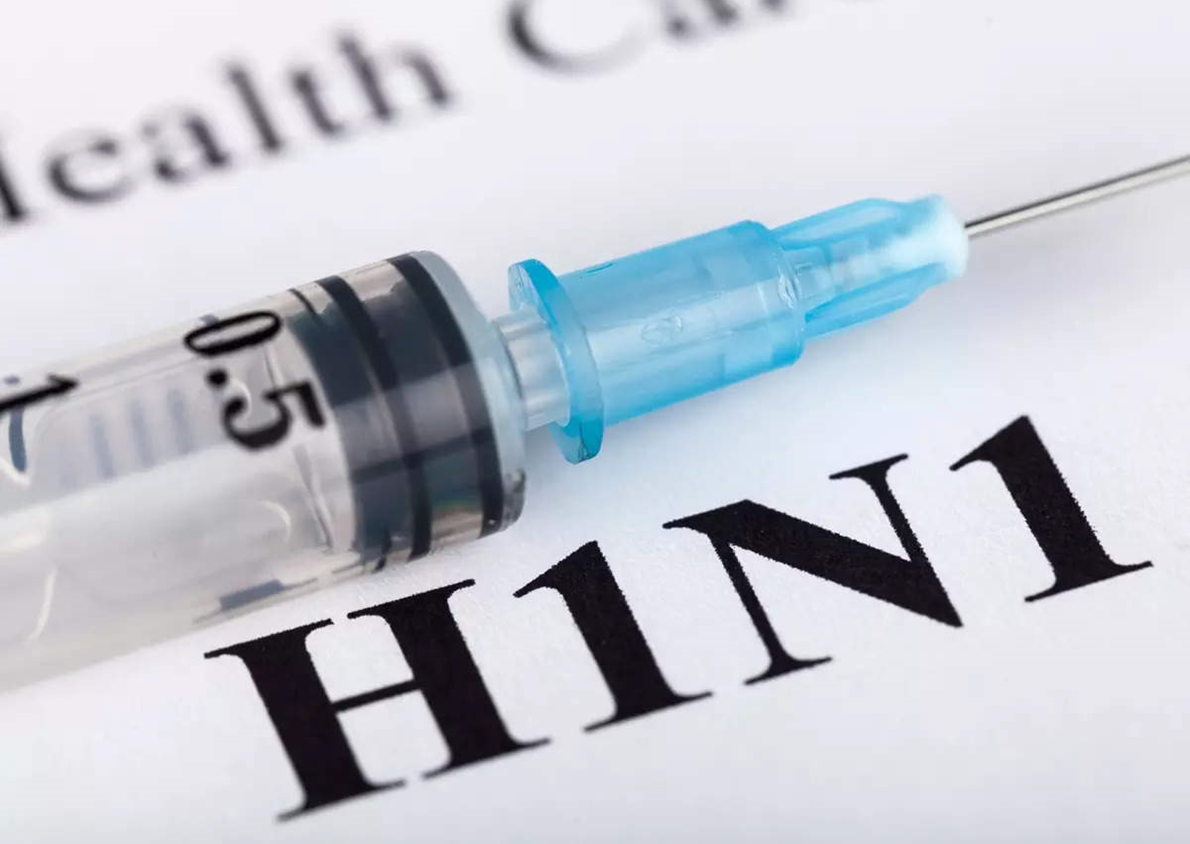

DEFINING KEY TERMS: Throughout this notebook, when the term “unvaccinated” is used, it refers specifically to the annual swine flu vaccinestill recommended today by the CDC. 

METHODOLOGY: Logistic Regression

TARGET: h1n1_vaccine 
      
      - 1 represents no vaccine
      - 0 represents vaccine

PERFORMANCE METRICS: Performance will be evaluated according to the area under the receiver operating characteristic curve (ROC) along with the accuracy, recall, precision, and f1 scores. A higher value indicates stronger performance.

# 2. Imports and Data

In [7]:
import pandas as pd
import numpy as np
from numpy import ravel
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures,\
Normalizer, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder

from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve, roc_auc_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold 

In [8]:
cd data

C:\Users\Jackson\Documents\flatiron\H1N1-Vaccines\data


In [9]:
trainfeatures = pd.read_csv('training_set_features.csv')
trainlabels = pd.read_csv('training_set_labels.csv')

In [10]:
trainfeatures.shape, trainlabels.shape

((26707, 36), (26707, 3))

Merging features and labels dataframes to create one comprehensive dataset.

In [11]:
df = trainfeatures.merge(trainlabels,on='respondent_id',how='outer')

In [12]:
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [13]:
df.h1n1_vaccine.value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

# 3. Exploratory Data Analysis

Checking for duplicates, checking null values, and exploring dtypes

In [14]:
df.duplicated().sum()

0

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In our question, we want to uncover who is will not receive a h1n1 vaccine, therefore, we will switch our target variable so that 0 represents receiving the vaccine and 1 represents not receiving the vaccine.

In [16]:
df.h1n1_vaccine = df.h1n1_vaccine.replace(0, "no vaccine")
df.h1n1_vaccine = df.h1n1_vaccine.replace(1, "vaccine")

In [17]:
df.h1n1_vaccine.value_counts()

no vaccine    21033
vaccine        5674
Name: h1n1_vaccine, dtype: int64

In [18]:
df.h1n1_vaccine = df.h1n1_vaccine.replace("no vaccine", 1)
df.h1n1_vaccine = df.h1n1_vaccine.replace("vaccine", 0)

In [19]:
df.h1n1_vaccine.value_counts()

1    21033
0     5674
Name: h1n1_vaccine, dtype: int64

In [20]:
df['h1n1_vaccine'].value_counts(normalize=True)

1    0.787546
0    0.212454
Name: h1n1_vaccine, dtype: float64

There may be a class imbalance issue given that 78.75% of the dataset did not receive the h1n1 vaccine.

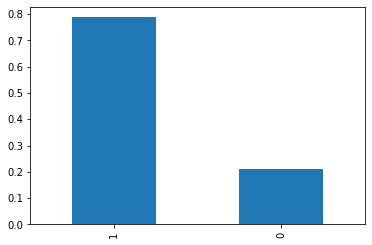

In [21]:
df['h1n1_vaccine'].value_counts(normalize=True).plot(kind='bar');

Let's explore the relationship of other categorical variables with the target variables.

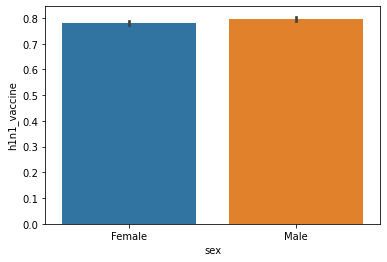

In [22]:
sns.barplot(x=df['sex'], y=df['h1n1_vaccine']);

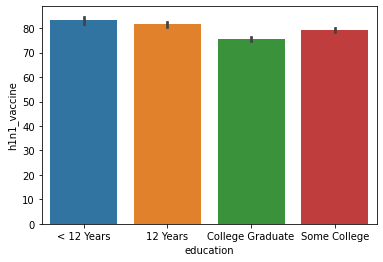

In [23]:
sns.barplot(x=df['education'], y=df['h1n1_vaccine'] * 100);

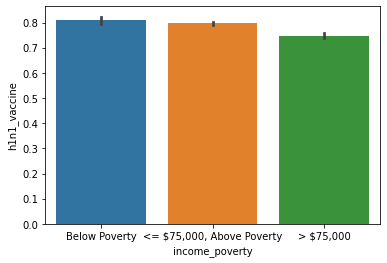

In [24]:
sns.barplot(x=df['income_poverty'], y=df['h1n1_vaccine']);

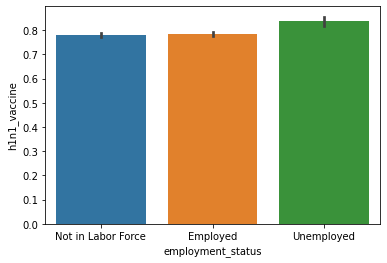

In [25]:
sns.barplot(x=df['employment_status'], y=df['h1n1_vaccine']);

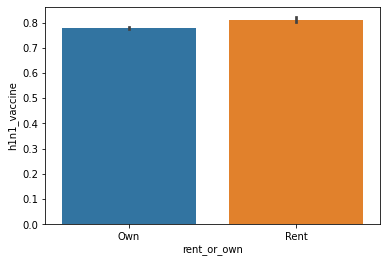

In [26]:
sns.barplot(x=df['rent_or_own'], y=df['h1n1_vaccine']);

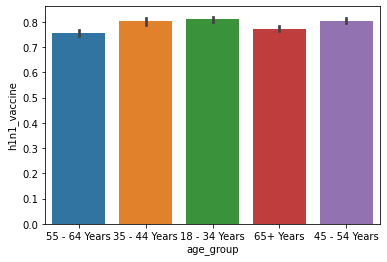

In [27]:
sns.barplot(x=df['age_group'], y=df['h1n1_vaccine']);

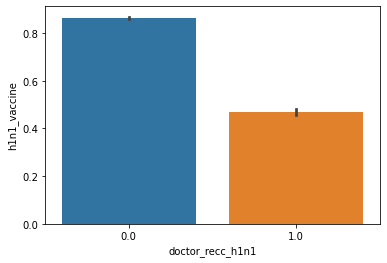

In [28]:
sns.barplot(x=df['doctor_recc_h1n1'], y=df['h1n1_vaccine']);

# 4. Pipeline Creation - H1N1 Vaccine and All Variables

Creating categorical, binary, and simple imputer only column lists to use in pipelines. 

In [29]:
df.sex.value_counts()

Female    15858
Male      10849
Name: sex, dtype: int64

In [30]:
df.marital_status.value_counts()

Married        13555
Not Married    11744
Name: marital_status, dtype: int64

In [31]:
df.rent_or_own.value_counts()

Own     18736
Rent     5929
Name: rent_or_own, dtype: int64

In [32]:
categorical_columns = ['age_group','education','race','income_poverty','employment_status', 'hhs_geo_region','census_msa',
                       'household_adults','household_children','employment_industry','employment_occupation']

#binary columns include columns that are binary but need to be one-hot-encoded because they are objects
binary_columns = ['sex','marital_status','rent_or_own']

#simple impute only includes: (1) binary variables that contain 0 and 1 already and (2) survey data that is on a scale from 0-x. 
simple_impute_only = ['opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc',
                       'opinion_seas_vacc_effective','opinion_seas_risk','opinion_seas_sick_from_vacc','h1n1_knowledge',
                       'h1n1_concern', 'behavioral_antiviral_meds','behavioral_avoidance', 'behavioral_face_mask',
                      'behavioral_wash_hands','behavioral_large_gatherings','behavioral_outside_home',
                      'behavioral_touch_face','doctor_recc_h1n1','doctor_recc_seasonal','chronic_med_condition',
                      'child_under_6_months','health_worker','health_insurance']

Our X and y exclude respondent ID and both the h1n1 and seasonal vaccine target variables. We are not paying attention to seasonal vaccines in this project.

In [33]:
X = df.iloc[:,1:-2]
y = df['h1n1_vaccine']

Split the data so that we have our training set and testing set.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [35]:
X_train.shape, X_test.shape

((20030, 35), (6677, 35))

Creating subpipes based on the needs of the respective columns.

In [36]:
subpipe_categorical = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

subpipe_binary = Pipeline([
    ('bin_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

subpipe_simple_impute_only = Pipeline([
    ('sio_impute', SimpleImputer(strategy='most_frequent'))
])

In [37]:
CT = ColumnTransformer(transformers=[
    ('categorical', subpipe_categorical, categorical_columns),
    ('binary', subpipe_binary, binary_columns),
    ('simple_impute_only', subpipe_simple_impute_only, simple_impute_only)
], remainder='passthrough')

# 4A. Dummy Model

Creating first dummy/baseline model to compare our following models to.

In [38]:
dummy_pipeline = Pipeline(steps=[
    ('CT',CT),
    ('dummy',DummyClassifier(strategy='most_frequent'))
])

In [39]:
dummy_pipeline.fit(X_train, y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

In [40]:
print('Training set score: ' + str(dummy_pipeline.score(X_train,y_train)))
print('Test set score: ' + str(dummy_pipeline.score(X_test,y_test)))

Training set score: 0.7874687968047928
Test set score: 0.7877789426389097


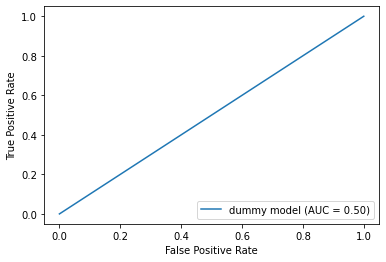

In [41]:
plot_roc_curve(dummy_pipeline, X_test, y_test, name='dummy model');

Our model must perform better than this! 

# 4B. First Simple Model

In [42]:
fsm_pipeline = Pipeline([
    ('CT',CT),
    ('first_simple_model', LogisticRegression())
])

In [43]:
fsm_pipeline.fit(X_train, y_train)

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

In [44]:
print('Training set score: ' + str(fsm_pipeline.score(X_train,y_train)))
print('Test set score: ' + str(fsm_pipeline.score(X_test,y_test)))

Training set score: 0.8379930104842735
Test set score: 0.8397483899955069


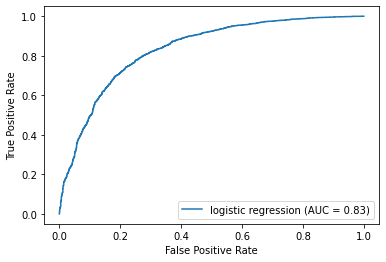

In [45]:
plot_roc_curve(fsm_pipeline, X_test, y_test, name='logistic regression');

This is an improvement from the dummy model. Let's tune it with gridsearching.

# 4C. Tuning First Simple Model with GridSearching

Creating parameters for the grid search. The gridsearch takes 25-40 minutes.

In [46]:
params = {
    'first_simple_model__solver' : ['liblinear','lbfgs'],
    'first_simple_model__max_iter': [10, 100,1000,10_000],
    'first_simple_model__C' : [0.0001, 0.001, 0.01, 0.1, 1],
    'first_simple_model__tol' : [0.0001, 0.001, 0.01, 0.1]
}

In [47]:
gridsearch = GridSearchCV(
    estimator = fsm_pipeline,
    param_grid=params,
    cv=5,
    verbose=1
)

In [48]:
gridsearch.fit(X_train,y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also r

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                        

In [49]:
best_params = gridsearch.best_params_
best_params

{'first_simple_model__C': 1,
 'first_simple_model__max_iter': 1000,
 'first_simple_model__solver': 'lbfgs',
 'first_simple_model__tol': 0.0001}

In [50]:
best_pipe = gridsearch.best_estimator_
best_pipe

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

In [51]:
result_df = pd.DataFrame.from_dict(gridsearch.cv_results_, orient='columns')
result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_first_simple_model__C,param_first_simple_model__max_iter,param_first_simple_model__solver,param_first_simple_model__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.880885,0.049838,0.038869,0.006160,0.0001,10,liblinear,0.0001,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,129
1,0.937784,0.056483,0.046684,0.007279,0.0001,10,liblinear,0.001,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,129
2,0.919495,0.028211,0.041104,0.003490,0.0001,10,liblinear,0.01,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,129
3,0.889961,0.025969,0.043143,0.002770,0.0001,10,liblinear,0.1,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,129
4,0.975332,0.079193,0.047178,0.002246,0.0001,10,lbfgs,0.0001,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,1.680623,0.172862,0.072073,0.017818,1,10000,liblinear,0.1,"{'first_simple_model__C': 1, 'first_simple_mod...",0.829006,0.830504,0.830255,0.835996,0.834249,0.832002,0.002656,61
156,4.065303,0.591684,0.066042,0.016377,1,10000,lbfgs,0.0001,"{'first_simple_model__C': 1, 'first_simple_mod...",0.831253,0.836995,0.839990,0.835497,0.836495,0.836046,0.002826,1
157,3.597559,0.423876,0.049316,0.002974,1,10000,lbfgs,0.001,"{'first_simple_model__C': 1, 'first_simple_mod...",0.831253,0.836995,0.839990,0.835497,0.836495,0.836046,0.002826,1
158,3.183125,0.138207,0.050066,0.007427,1,10000,lbfgs,0.01,"{'first_simple_model__C': 1, 'first_simple_mod...",0.831253,0.836995,0.839990,0.835497,0.836495,0.836046,0.002826,1


In [52]:
print('Training set score: ' + str(best_pipe.score(X_train,y_train)))
print('Test set score: ' + str(best_pipe.score(X_test,y_test)))

Training set score: 0.8380928607089366
Test set score: 0.8398981578553243


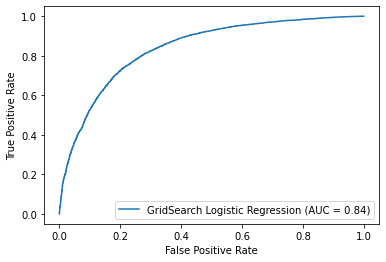

In [53]:
plot_roc_curve(best_pipe, X_train, y_train, name='GridSearch Logistic Regression');

In [54]:
cv = cross_validate(best_pipe, X_train, y_train, scoring=['r2','neg_mean_squared_error'], return_train_score=True)
cv

{'fit_time': array([3.6902709 , 4.53405952, 6.35776162, 4.45726418, 4.20365095]),
 'score_time': array([0.06106377, 0.06818271, 0.09899735, 0.06419563, 0.0666399 ]),
 'test_r2': array([-0.00862265,  0.02569439,  0.04359894,  0.01758479,  0.02354786]),
 'train_r2': array([0.03878911, 0.03468774, 0.02611216, 0.02627628, 0.02925973]),
 'test_neg_mean_squared_error': array([-0.16874688, -0.16300549, -0.16000999, -0.16450325, -0.16350474]),
 'train_neg_mean_squared_error': array([-0.16088367, -0.16157014, -0.16300549, -0.16294309, -0.16244383])}

In [55]:
y_preds4c = best_pipe.predict(X_test)

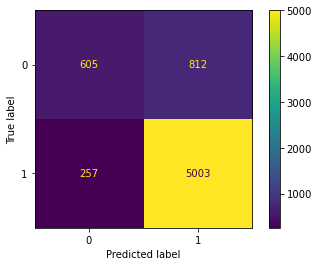

In [56]:
plot_confusion_matrix(best_pipe, X_test, y_test);

In [57]:
print(f"""
Our 4C model's accuracy on the test set is {round(accuracy_score(y_test, y_preds4c), 4) * 100}%. \n
Our 4C model's recall on the test set is {round(recall_score(y_test, y_preds4c), 5) * 100}%. \n
Our 4C model's precision on the test set is {round(precision_score(y_test, y_preds4c), 4) * 100}%. \n
Our 4C model's f1-score on the test is {round(f1_score(y_test, y_preds4c), 3) * 100}%.
""")


Our 4C model's accuracy on the test set is 83.99%. 

Our 4C model's recall on the test set is 95.114%. 

Our 4C model's precision on the test set is 86.04%. 

Our 4C model's f1-score on the test is 90.3%.



Tuning our model based on the gridsearch improved our model! 

# 4D. Logistic Regression with SMOTE

Earlier we mentioned a possible class imbalance (section 3). Let's see if adding SMOTE to the model improves the performance.

In [58]:
smote_pipeline = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42)),
    ('best_pipe', LogisticRegression(C=1,max_iter=100, solver='lbfgs',tol=.0001))
])

In [59]:
smote_pipeline.fit(X_train, y_train)

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

In [60]:
print('Training set score: ' + str(smote_pipeline.score(X_train,y_train)))
print('Test set score: ' + str(smote_pipeline.score(X_test,y_test)))

Training set score: 0.7839740389415876
Test set score: 0.7831361389845739


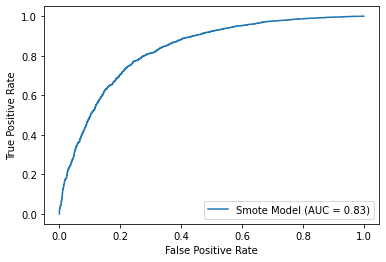

In [61]:
plot_roc_curve(smote_pipeline, X_test, y_test, name='Smote Model');

In [62]:
cv = cross_validate(smote_pipeline, X_train, y_train, scoring=['r2','neg_mean_squared_error'], return_train_score=True)
cv

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

{'fit_time': array([5.36015129, 5.68381691, 6.87556553, 5.72984719, 6.17731452]),
 'score_time': array([0.04962158, 0.07870102, 0.066926  , 0.05460262, 0.05584621]),
 'test_r2': array([-0.3786499 , -0.29807945, -0.35179308, -0.2418086 , -0.2999485 ]),
 'train_r2': array([-0.26172911, -0.28894726, -0.27552461, -0.30861607, -0.28586725]),
 'test_neg_mean_squared_error': array([-0.23065402, -0.21717424, -0.22616076, -0.20793809, -0.21767349]),
 'train_neg_mean_squared_error': array([-0.21118323, -0.21573889, -0.21349226, -0.21898402, -0.21517723])}

In [63]:
y_preds4d = smote_pipeline.predict(X_test)

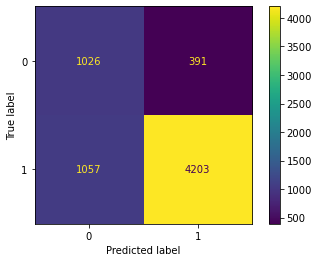

In [64]:
plot_confusion_matrix(smote_pipeline, X_test, y_test);

In [65]:
print(f"""
Our 4d model's accuracy on the test set is {round(accuracy_score(y_test, y_preds4d), 4) * 100}%. \n
Our 4d model's recall on the test set is {round(recall_score(y_test, y_preds4d), 5) * 100}%. \n
Our 4d model's precision on the test set is {round(precision_score(y_test, y_preds4d), 4) * 100}%. \n
Our 4d model's f1-score on the test is {round(f1_score(y_test, y_preds4d), 3) * 100}%.
""")


Our 4d model's accuracy on the test set is 78.31%. 

Our 4d model's recall on the test set is 79.905%. 

Our 4d model's precision on the test set is 91.49000000000001%. 

Our 4d model's f1-score on the test is 85.3%.



Adding SMOTE to the model decreased it's performance so if we are going to move forward with including all the columns in our model, we will move forward with the gridsearch logistic regression without SMOTE. 

# 5. Pipeline Creation - H1N1 Vaccine and Select Columns

Before choosing our model, let's explore what happens to our model if we decrease the number of columns/variables.

In [66]:
X_select = df[['age_group', 'education', 'race', 'income_poverty', 'employment_status', 'marital_status', 'sex','hhs_geo_region']]
y_select = df['h1n1_vaccine']

In [67]:
categorical_columns = ['age_group', 'education', 'race', 'income_poverty', 'employment_status', 'hhs_geo_region']
binary_columns = ['sex', 'marital_status']

In [68]:
X_train_select, X_test_select, y_train_select, y_test_select = train_test_split(X_select, y_select, random_state=42)

In [69]:
subpipe_categorical = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

subpipe_binary = Pipeline([
    ('bin_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [70]:
CT = ColumnTransformer(transformers=[
    ('categorical', subpipe_categorical, categorical_columns),
    ('binary', subpipe_binary, binary_columns)
], remainder='passthrough')

# 5A. Dummy Model

Creating our dummy model for our new pipelines that include only select columns.

In [71]:
dummy_pipeline = Pipeline(steps=[
    ('CT', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [72]:
dummy_pipeline.fit(X_train_select,y_train_select)

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

In [73]:
print('Training set score: ' + str(dummy_pipeline.score(X_train_select,y_train_select)))
print('Test set score: ' + str(dummy_pipeline.score(X_test_select,y_test_select)))

Training set score: 0.7874687968047928
Test set score: 0.7877789426389097


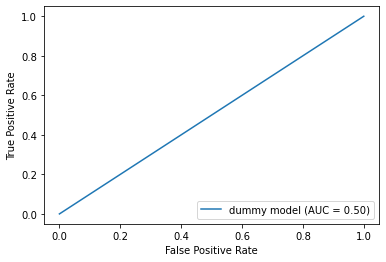

In [74]:
plot_roc_curve(dummy_pipeline, X_test_select, y_test_select, name='dummy model');

# 5B. First Simple Model for Select Columns

In [75]:
fsm_pipeline = Pipeline([
    ('CT', CT),
    ('first_simple_model', LogisticRegression())
])

In [76]:
fsm_pipeline.fit(X_train_select,y_train_select)

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

In [77]:
print('Training set score: ' + str(fsm_pipeline.score(X_train_select,y_train_select)))
print('Test set score: ' + str(fsm_pipeline.score(X_test_select,y_test_select)))

Training set score: 0.7874687968047928
Test set score: 0.7877789426389097


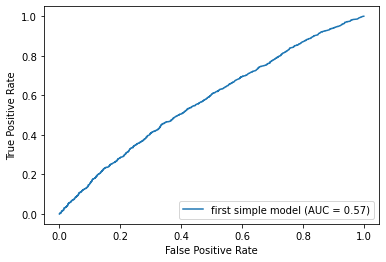

In [78]:
plot_roc_curve(fsm_pipeline, X_test_select, y_test_select, name='first simple model');

This does not look good. Let's gridsearch to see if it improves our model at all.

# 5C. Tuning First Simple Model with GridSearching

In [79]:
params = {
    'first_simple_model__solver' : ['liblinear','lbfgs'],
    'first_simple_model__max_iter': [10, 100,1000,10_000],
    'first_simple_model__C' : [0.0001, 0.001, 0.01, 0.1, 1],
    'first_simple_model__tol' : [0.0001, 0.001, 0.01, 0.1]
}

In [80]:
gridsearch_select = GridSearchCV(
    estimator = fsm_pipeline,
    param_grid = params,
    cv=5,
    verbose=1)

In [81]:
gridsearch_select.fit(X_train_select,y_train_select)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also r

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jackson\anaconda\anaconda-this one\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                        

In [82]:
best_params_select = gridsearch_select.best_params_
best_params_select

{'first_simple_model__C': 0.0001,
 'first_simple_model__max_iter': 10,
 'first_simple_model__solver': 'liblinear',
 'first_simple_model__tol': 0.0001}

In [83]:
best_pipe_select = gridsearch_select.best_estimator_
best_pipe_select

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

In [84]:
result_df = pd.DataFrame.from_dict(gridsearch_select.cv_results_,orient='columns')
result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_first_simple_model__C,param_first_simple_model__max_iter,param_first_simple_model__solver,param_first_simple_model__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.697323,0.056614,0.024728,0.007719,0.0001,10,liblinear,0.0001,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
1,0.610434,0.030177,0.025971,0.004192,0.0001,10,liblinear,0.001,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
2,0.564089,0.015560,0.021574,0.005424,0.0001,10,liblinear,0.01,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
3,0.581332,0.015916,0.018014,0.003658,0.0001,10,liblinear,0.1,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
4,0.624295,0.048378,0.024010,0.005744,0.0001,10,lbfgs,0.0001,"{'first_simple_model__C': 0.0001, 'first_simpl...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.404577,0.008603,0.018508,0.004068,1,10000,liblinear,0.1,"{'first_simple_model__C': 1, 'first_simple_mod...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
156,0.526148,0.013045,0.009537,0.003768,1,10000,lbfgs,0.0001,"{'first_simple_model__C': 1, 'first_simple_mod...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
157,0.526880,0.005013,0.013321,0.005057,1,10000,lbfgs,0.001,"{'first_simple_model__C': 1, 'first_simple_mod...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1
158,0.530525,0.008448,0.015449,0.003291,1,10000,lbfgs,0.01,"{'first_simple_model__C': 1, 'first_simple_mod...",0.787569,0.787569,0.787569,0.787319,0.787319,0.787469,0.000122,1


In [85]:
print('Training set score: ' + str(best_pipe_select.score(X_train_select,y_train)))
print('Test set score: ' + str(best_pipe_select.score(X_test_select,y_test)))

Training set score: 0.7874687968047928
Test set score: 0.7877789426389097


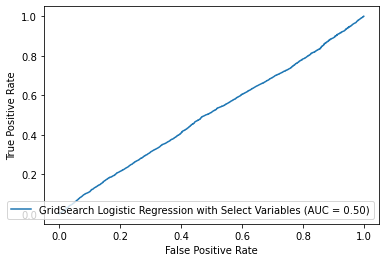

In [86]:
plot_roc_curve(best_pipe_select, X_train_select, y_train_select, name = 'GridSearch Logistic Regression with Select Variables');

Overall, this is not a good performance. Let's go back to using all columns in our model.

# 6. FINAL STAGE - Exploring Predictions

Refer to section 4C of selecting the best model including all the variables.

In [87]:
final_model = best_pipe
final_model

Pipeline(steps=[('CT',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['age_group', 'education',
                                                   'race', 'income_poverty',
                                                   'employment_status',
                                                   'hhs_

# 6A. Final Model Evaluation

Let's evaluate our model once more just to be extra careful.

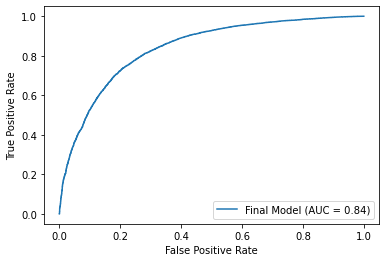

In [88]:
plot_roc_curve(best_pipe, X_train, y_train, name='Final Model');

In [89]:
print('Training set score: ' + str(final_model.score(X_train,y_train)))
print('Test set score: ' + str(final_model.score(X_test,y_test)))

Training set score: 0.8380928607089366
Test set score: 0.8398981578553243


In [90]:
cv = cross_validate(final_model, X_train, y_train, scoring=['r2','neg_mean_squared_error'], return_train_score=True)
cv

{'fit_time': array([2.57130599, 2.36422157, 2.88924766, 2.47432661, 2.90024543]),
 'score_time': array([0.03163362, 0.03871799, 0.04360485, 0.04442763, 0.03962636]),
 'test_r2': array([-0.00862265,  0.02569439,  0.04359894,  0.01758479,  0.02354786]),
 'train_r2': array([0.03878911, 0.03468774, 0.02611216, 0.02627628, 0.02925973]),
 'test_neg_mean_squared_error': array([-0.16874688, -0.16300549, -0.16000999, -0.16450325, -0.16350474]),
 'train_neg_mean_squared_error': array([-0.16088367, -0.16157014, -0.16300549, -0.16294309, -0.16244383])}

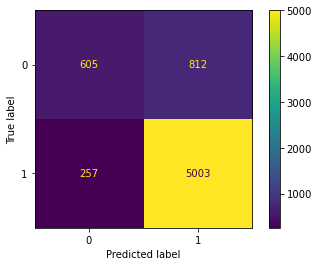

In [91]:
plot_confusion_matrix(final_model, X_test, y_test);

In [92]:
final_preds = final_model.predict(X_test)

# 6B. Final Model Interpretation 

In [93]:
print(f"""
The final model's accuracy on the test set is {round(accuracy_score(y_test, final_preds), 4) * 100}%. \n
The final model's recall on the test set is {round(recall_score(y_test, final_preds), 4) * 100}%. \n
The final model's precision on the test set is {round(precision_score(y_test, final_preds), 4) * 100}%. \n
The final model's f1-score on the test is {round(f1_score(y_test, final_preds), 4) * 100}%. \n
The final model's ROC AUC score on the test is {round(roc_auc_score(y_test, final_preds, average='macro'), 5) * 100}%. 
""")


The final model's accuracy on the test set is 83.99%. 

The final model's recall on the test set is 95.11%. 

The final model's precision on the test set is 86.04%. 

The final model's f1-score on the test is 90.35%. 

The final model's ROC AUC score on the test is 68.905%. 



INTERPRETATION: While the final model’s overall accuracy score was 84%, the recall rate was 95%. This tells us that of individuals who will not receive the vaccine, the model will accurately predict 95% of them. This is good news for us because, for this business question, we are mostly concerned with identifying unvaccinated individuals. It won’t hurt to market to an individual who will indeed get the vaccine. We would rather err on the side of identifying a larger volume of unvaccinated individuals. Let’s take a sneak peak at what this machine learning model tells us. 

# 6C. Creating Predictions DataFrame 

Let's create a new dataframe that includes our predictions to evaluate what the predictions tell us about people less likely to receive the vaccine.

In [94]:
X_preds = X_test.copy()

In [95]:
X_preds['Predictions'] = final_preds
X_preds['True Values'] = y_test

In [96]:
X_preds

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,Predictions,True Values
15772,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,atmpeygn,"MSA, Principle City",NaN,NaN,NaN,NaN,1,1
9407,3.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,...,NaN,NaN,fpwskwrf,"MSA, Principle City",1.0,1.0,NaN,NaN,1,1
16515,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,Own,Employed,atmpeygn,"MSA, Not Principle City",0.0,1.0,mfikgejo,mxkfnird,1,1
23353,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,Own,Employed,bhuqouqj,Non-MSA,1.0,2.0,cfqqtusy,xtkaffoo,1,1
10008,1.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,lrircsnp,"MSA, Principle City",1.0,0.0,wxleyezf,xtkaffoo,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25990,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Rent,Employed,oxchjgsf,Non-MSA,1.0,0.0,ldnlellj,hodpvpew,1,1
14302,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Own,Employed,lrircsnp,"MSA, Principle City",1.0,0.0,mcubkhph,ukymxvdu,1,1
3817,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,Own,Employed,bhuqouqj,"MSA, Principle City",1.0,0.0,wlfvacwt,xtkaffoo,1,0
13912,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Own,Employed,bhuqouqj,"MSA, Not Principle City",1.0,1.0,mfikgejo,mxkfnird,1,1


# 6D. Exploring Data Based on Target Predictions 

Creating a function to explore the relationship between our dependent variable of h1n1 vaccine predictions and various independent variables in our dataset.

In [158]:
def explore(x):
    fig, ax = plt.subplots(figsize=(24,12))
    sns.barplot(x=x, y='Predictions', palette='colorblind', data=X_preds);
    
    x_groupby = (X_preds.groupby([x]).mean().sort_values(by='Predictions', ascending=False))
    x_groupby = x_groupby[['Predictions']]
    print(x_groupby)

                    Predictions
employment_status              
Unemployed             0.926630
Employed               0.865459
Not in Labor Force     0.862891


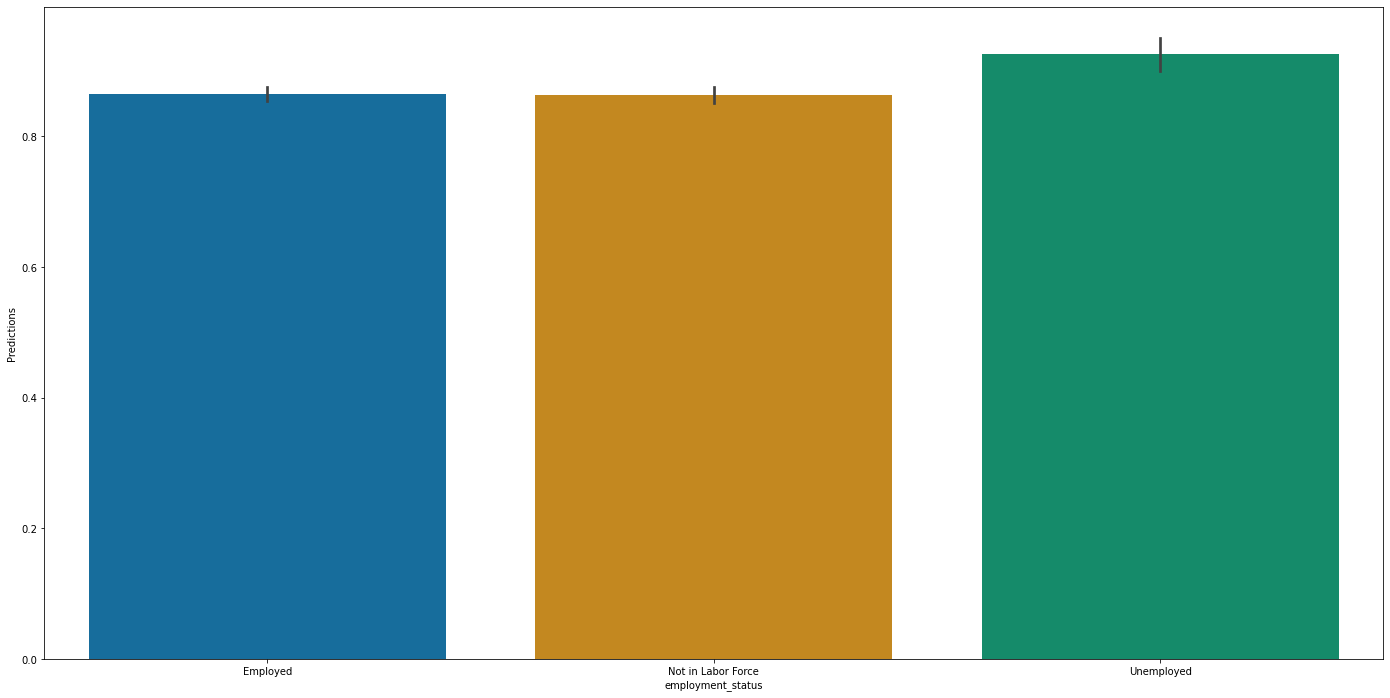

In [159]:
explore('employment_status')

               Predictions
age_group                 
18 - 34 Years     0.893449
45 - 54 Years     0.890869
35 - 44 Years     0.886179
65+ Years         0.851225
55 - 64 Years     0.843956


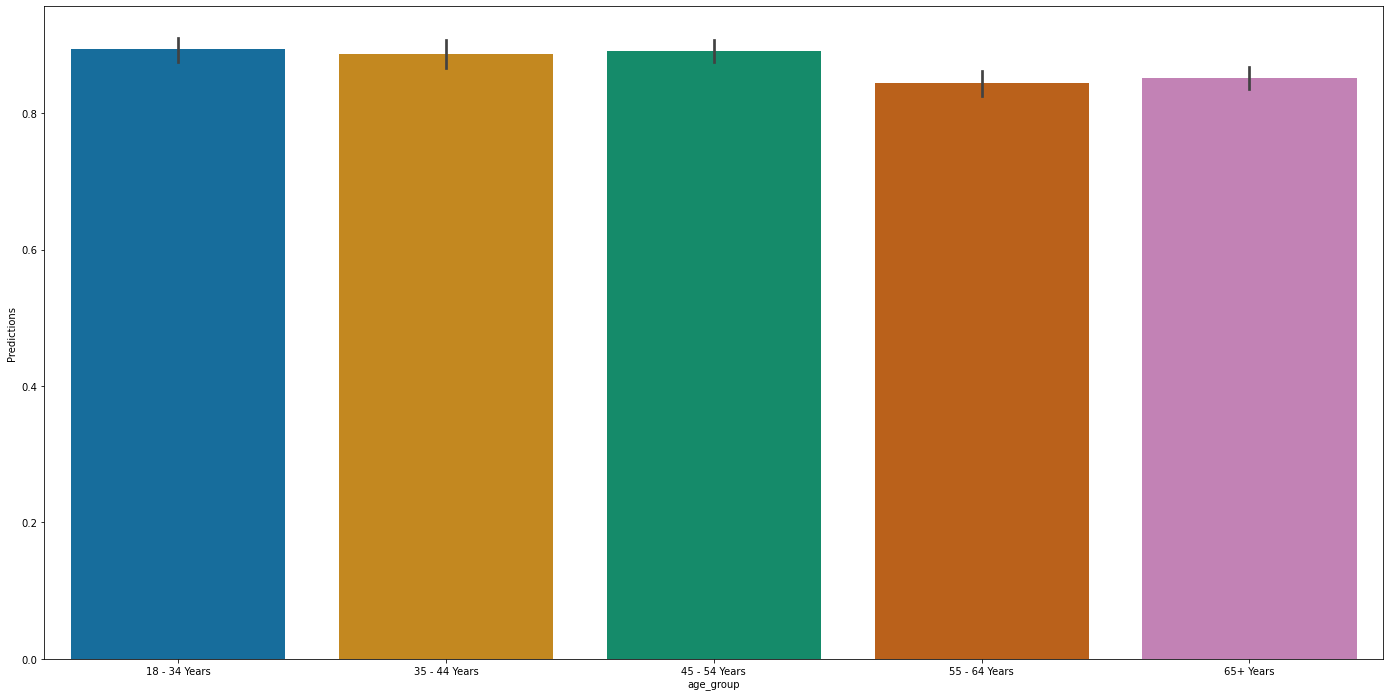

In [160]:
explore('age_group')

                Predictions
hhs_geo_region             
dqpwygqj           0.909420
lzgpxyit           0.902615
qufhixun           0.888158
kbazzjca           0.881579
fpwskwrf           0.879121
lrircsnp           0.869307
oxchjgsf           0.863570
atmpeygn           0.839530
bhuqouqj           0.838057
mlyzmhmf           0.825043


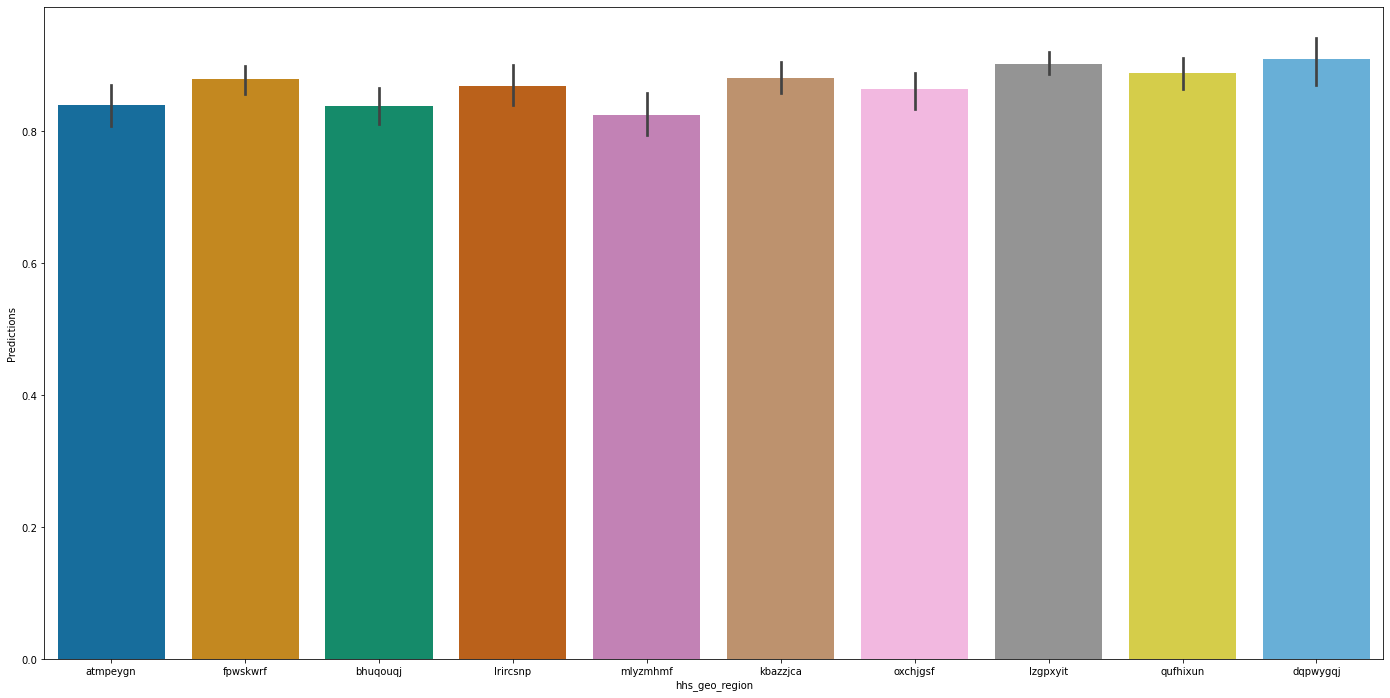

In [162]:
explore('hhs_geo_region')
#coded in random strings for privacy purposes

             Predictions
rent_or_own             
Rent            0.900332
Own             0.856097


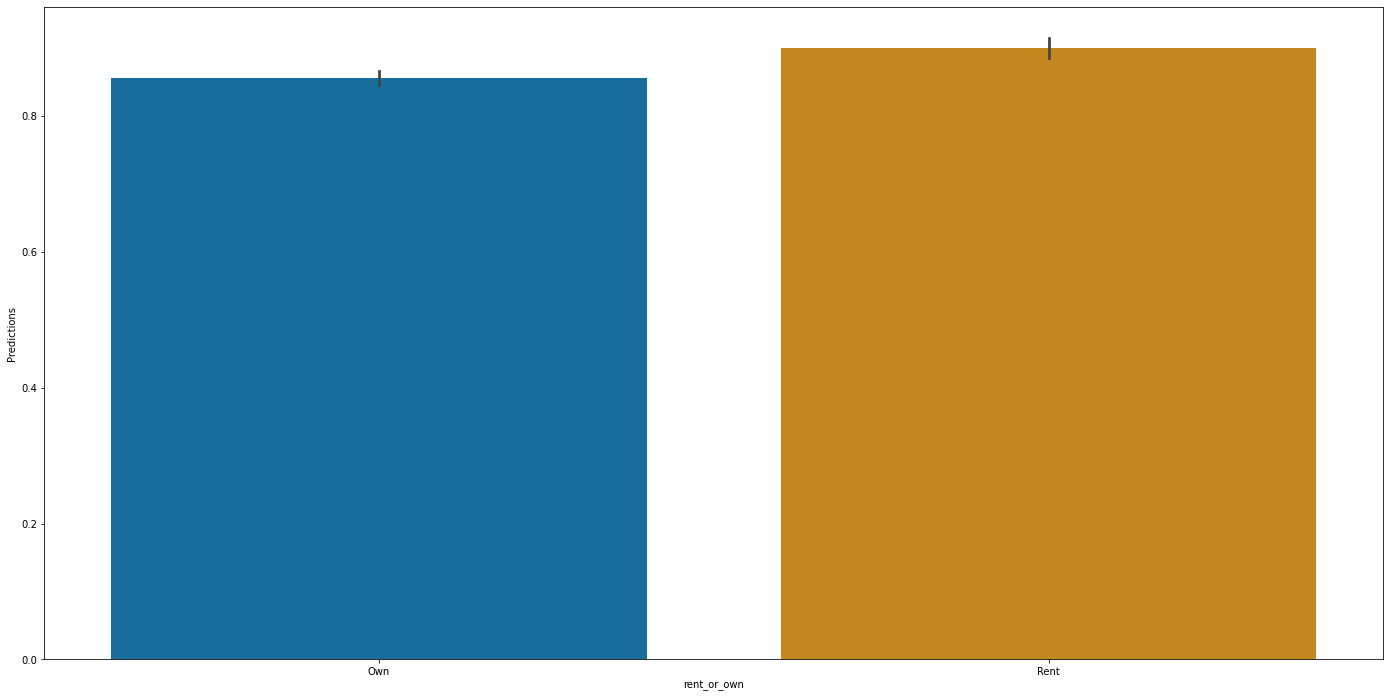

In [163]:
explore('rent_or_own')

                          Predictions
census_msa                           
MSA, Principle City          0.881758
MSA, Not Principle  City     0.870540
Non-MSA                      0.859259


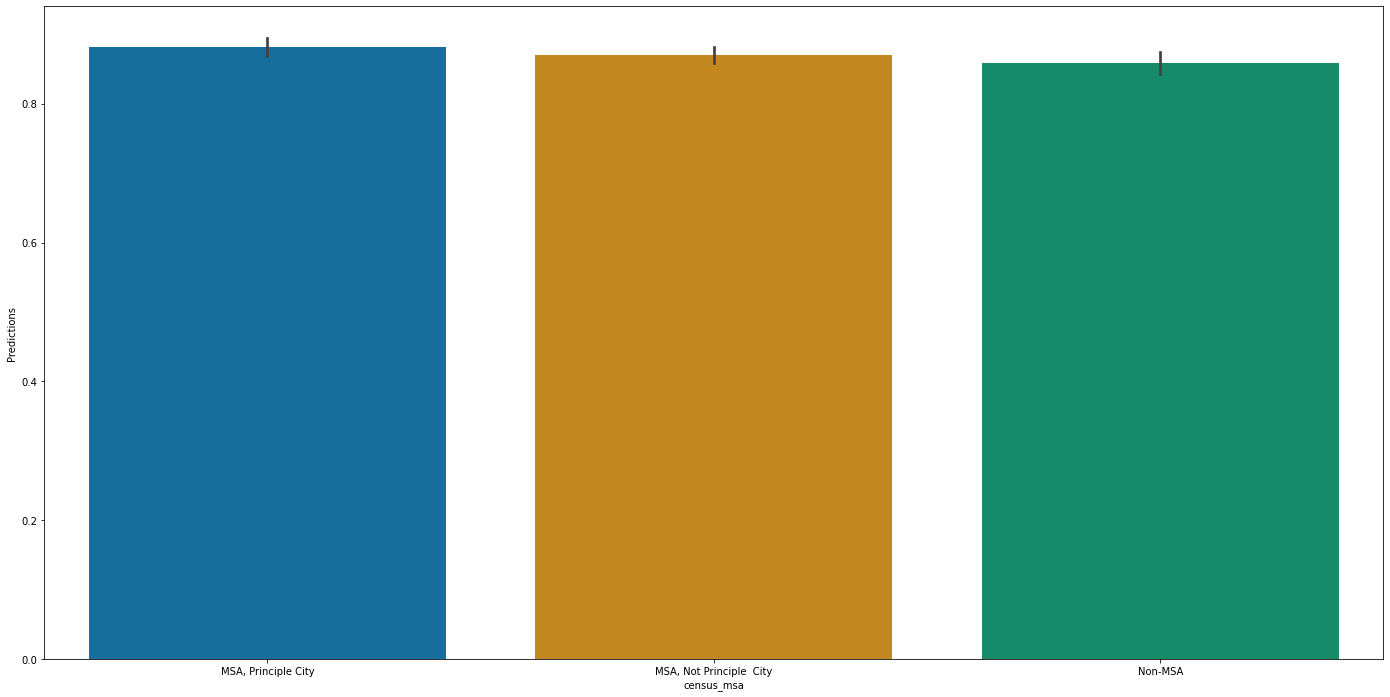

In [164]:
explore('census_msa')

                  Predictions
education                    
< 12 Years           0.915423
12 Years             0.897170
Some College         0.880000
College Graduate     0.832610


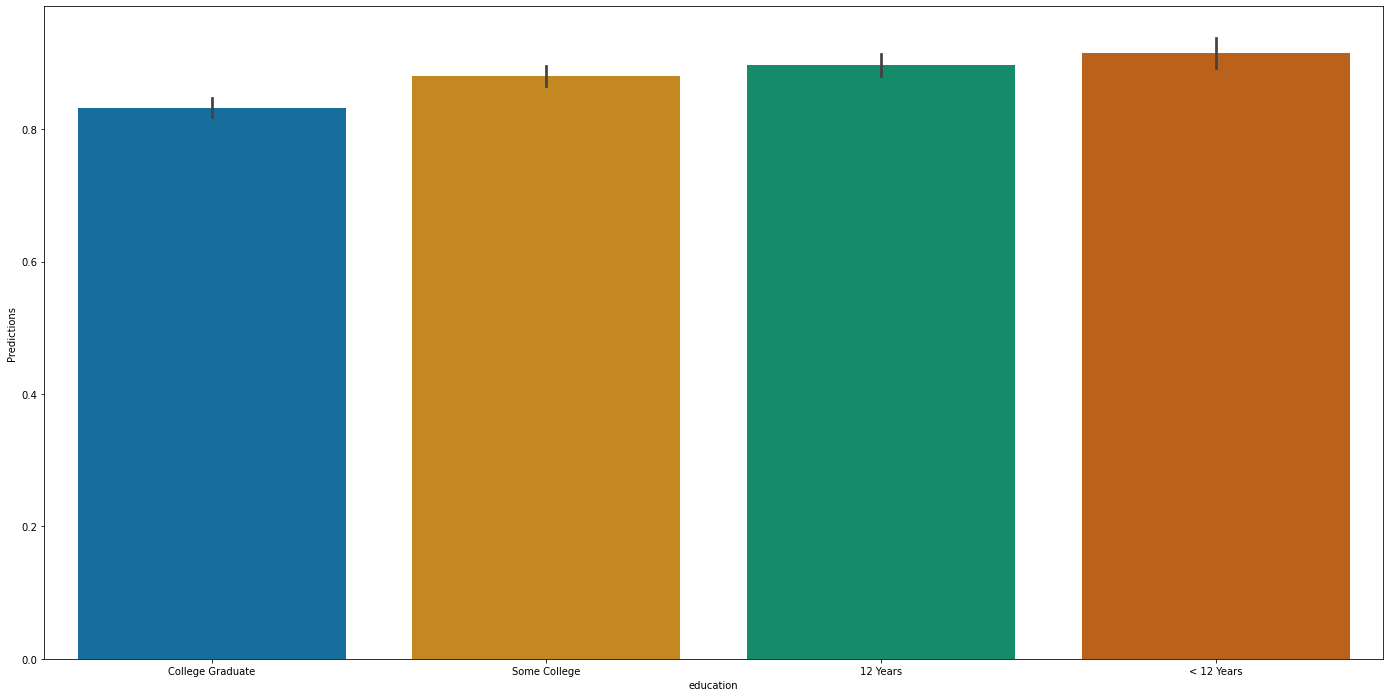

In [165]:
explore('education')

                  Predictions
doctor_recc_h1n1             
0.0                  0.976353
1.0                  0.452292


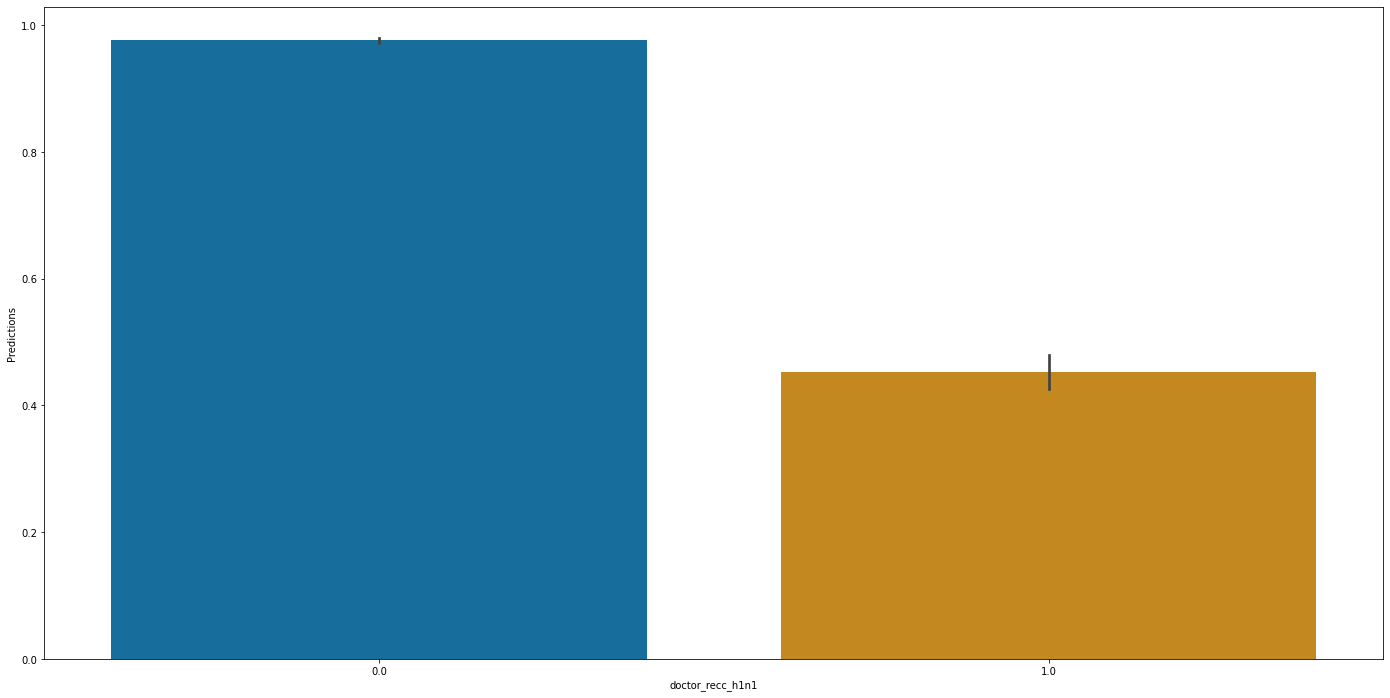

In [166]:
explore('doctor_recc_h1n1')

                Predictions
marital_status             
Not Married        0.893410
Married            0.845785


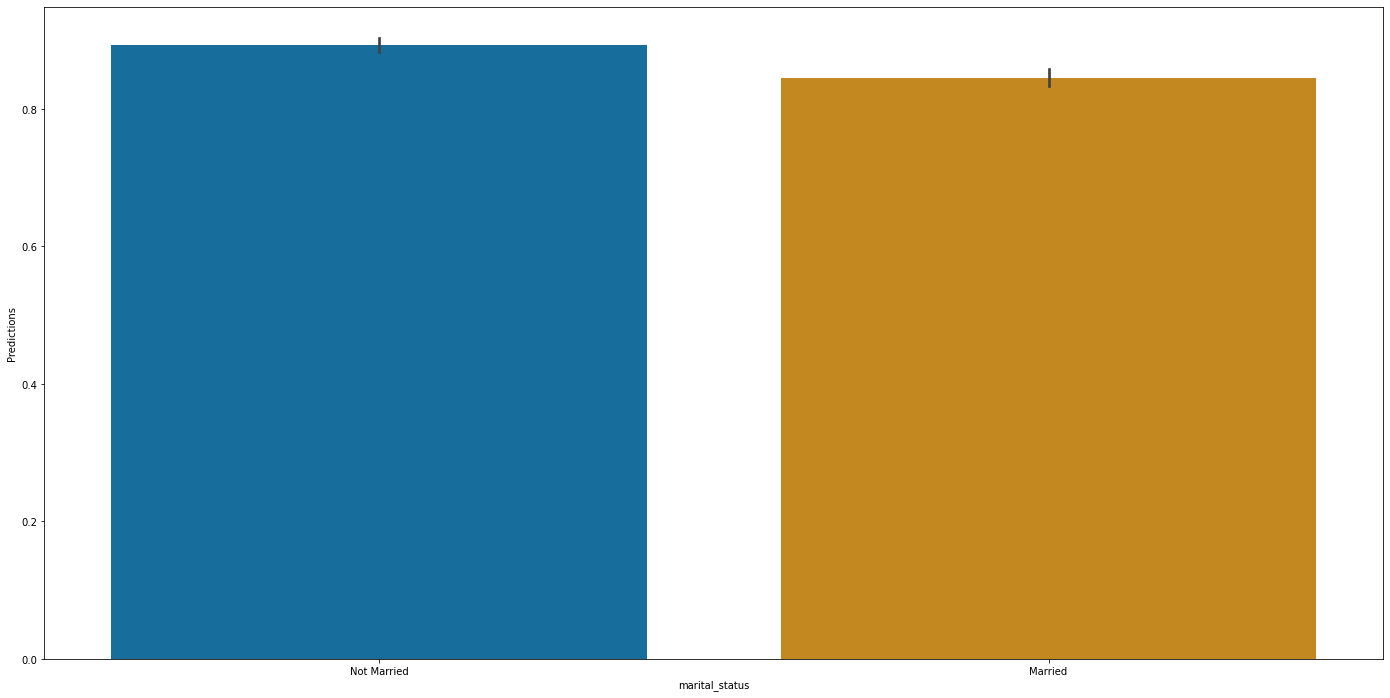

In [167]:
explore('marital_status')

                      Predictions
child_under_6_months             
0.0                      0.876754
1.0                      0.778793


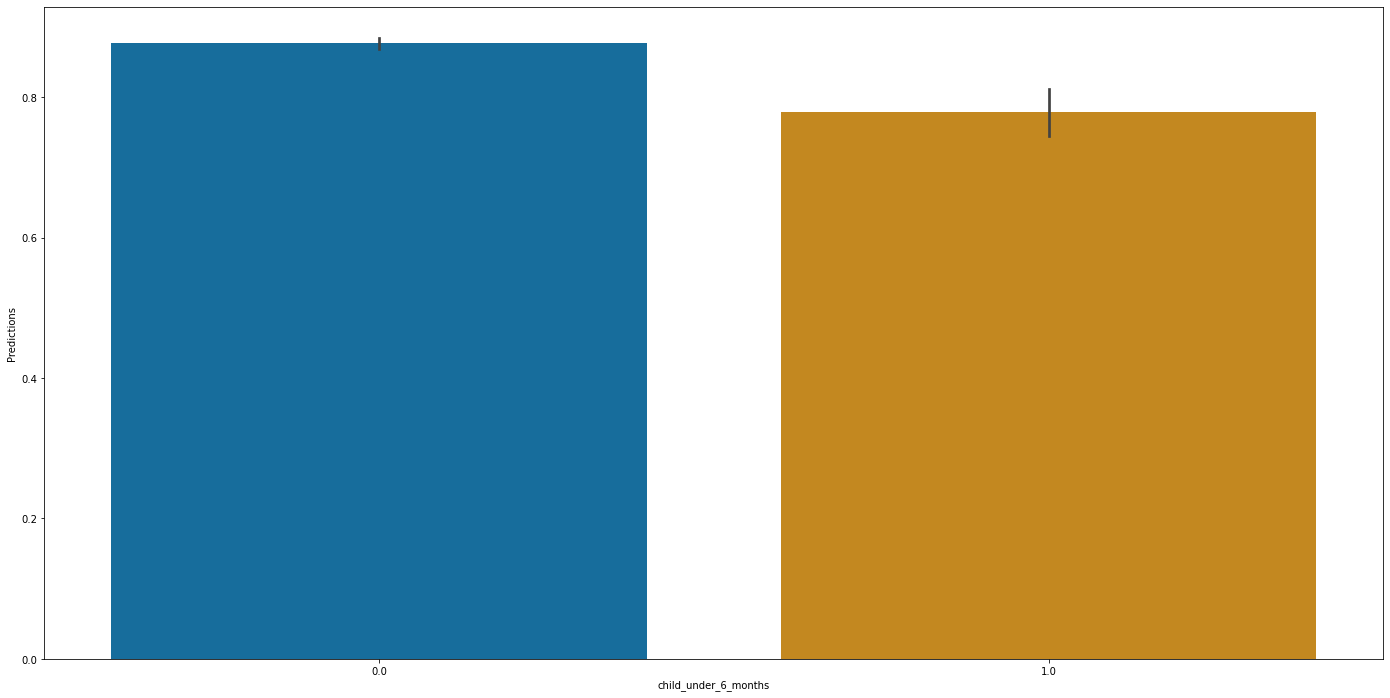

In [168]:
explore('child_under_6_months')

                  Predictions
household_adults             
3.0                  0.888112
0.0                  0.882812
2.0                  0.881471
1.0                  0.858794


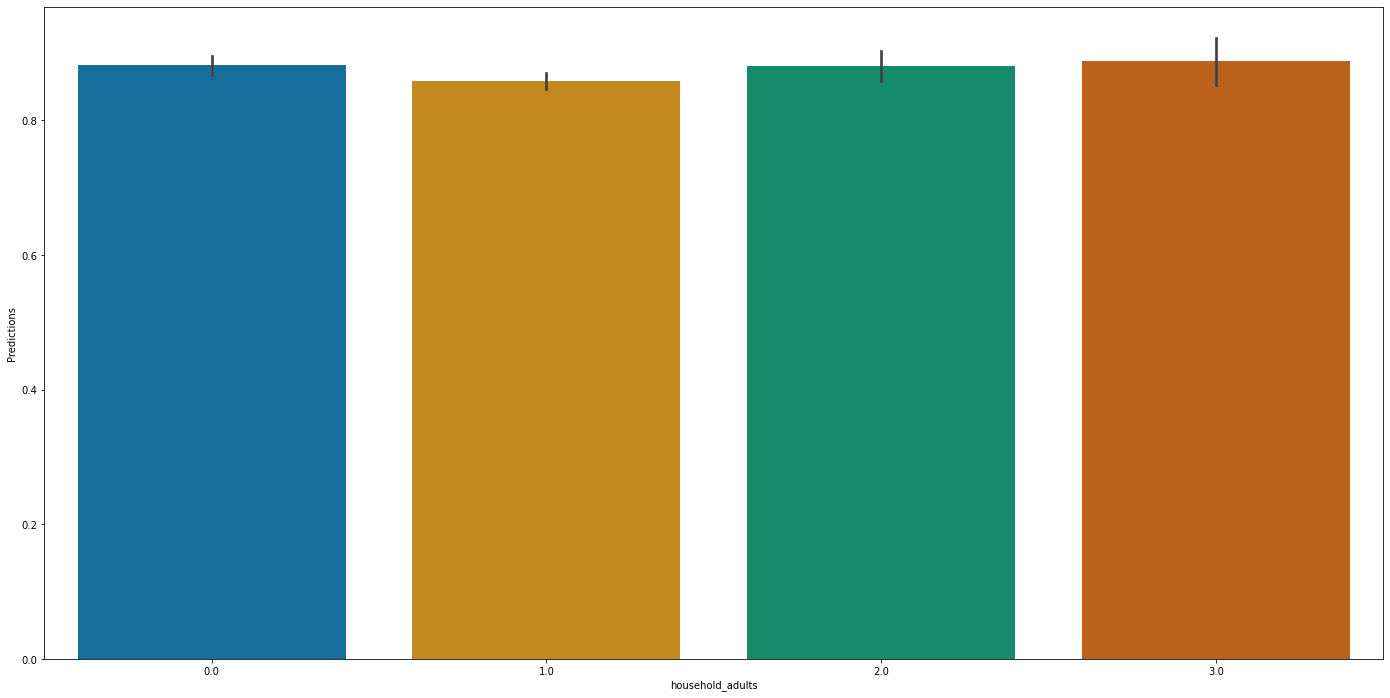

In [169]:
explore('household_adults')

                    Predictions
household_children             
3.0                    0.886792
1.0                    0.878517
2.0                    0.876033
0.0                    0.866140


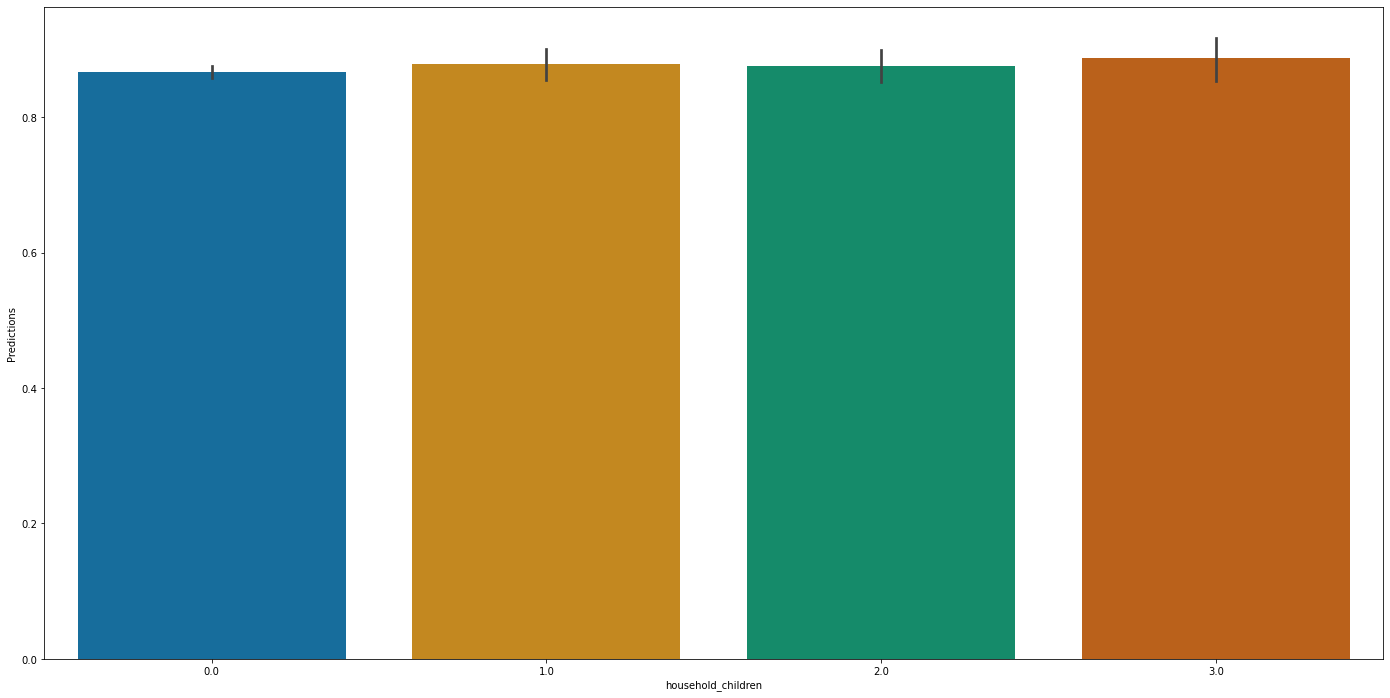

In [170]:
explore('household_children')

                   Predictions
race                          
Black                 0.936426
Other or Multiple     0.881266
Hispanic              0.870824
White                 0.862920


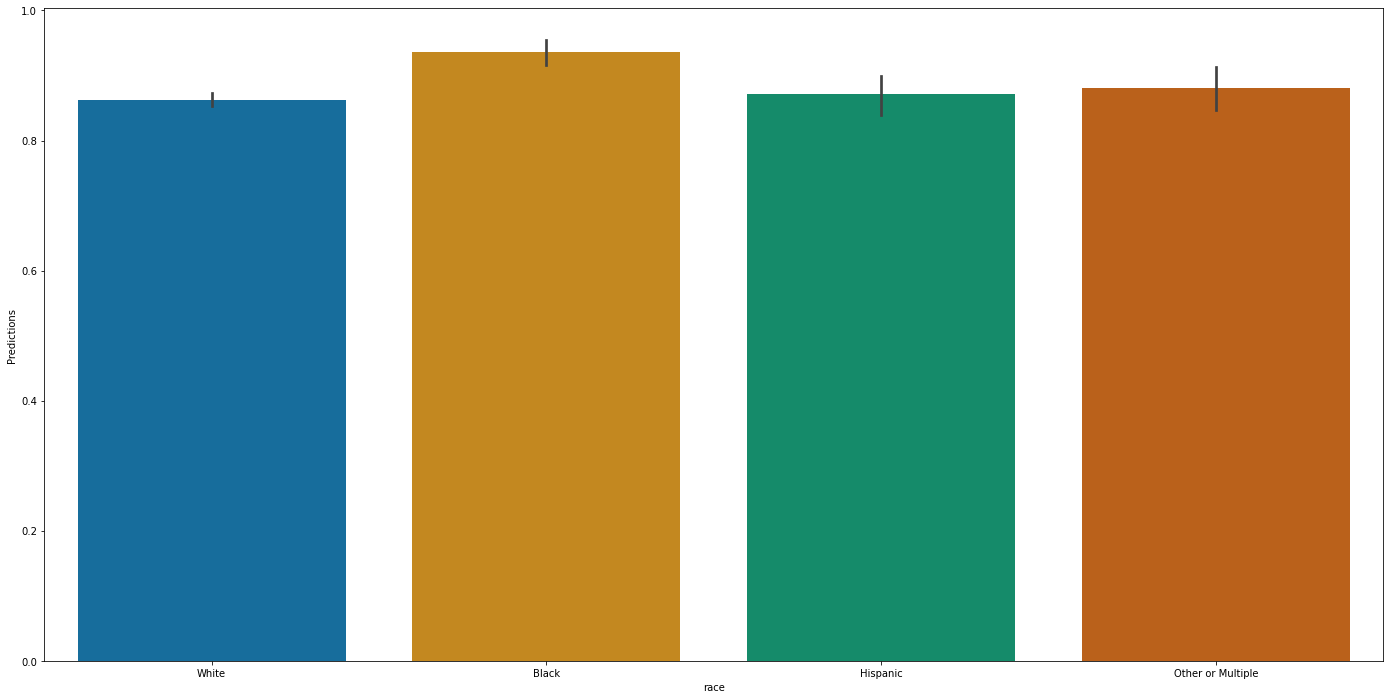

In [171]:
explore('race')

                           Predictions
income_poverty                        
Below Poverty                 0.898860
<= $75,000, Above Poverty     0.880876
> $75,000                     0.829738


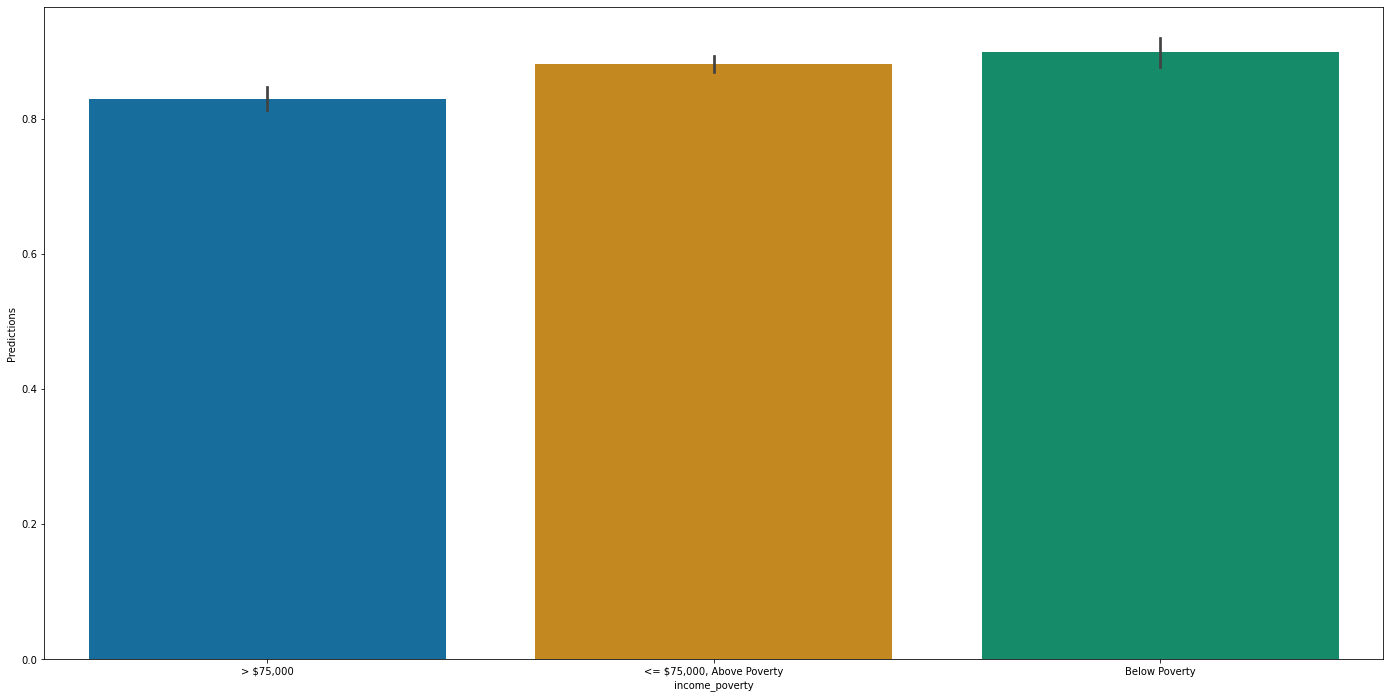

In [172]:
explore('income_poverty')

                       Predictions
employment_occupation             
pvmttkik                  1.000000
qxajmpny                  0.992537
rcertsgn                  0.984127
xgwztkwe                  0.947955
xqwwgdyp                  0.947368
tfqavkke                  0.935185
ukymxvdu                  0.925532
ccgxvspp                  0.924051
uqqtjvyb                  0.921739
hfxkjkmi                  0.918478
mxkfnird                  0.916216
vlluhbov                  0.901099
dlvbwzss                  0.890909
oijqvulv                  0.880435
kldqjyjy                  0.877358
xtkaffoo                  0.876623
xzmlyyjv                  0.862069
emcorrxb                  0.853659
hodpvpew                  0.843750
bxpfxfdn                  0.800000
haliazsg                  0.594203
cmhcxjea                  0.569444
dcjcmpih                  0.322581


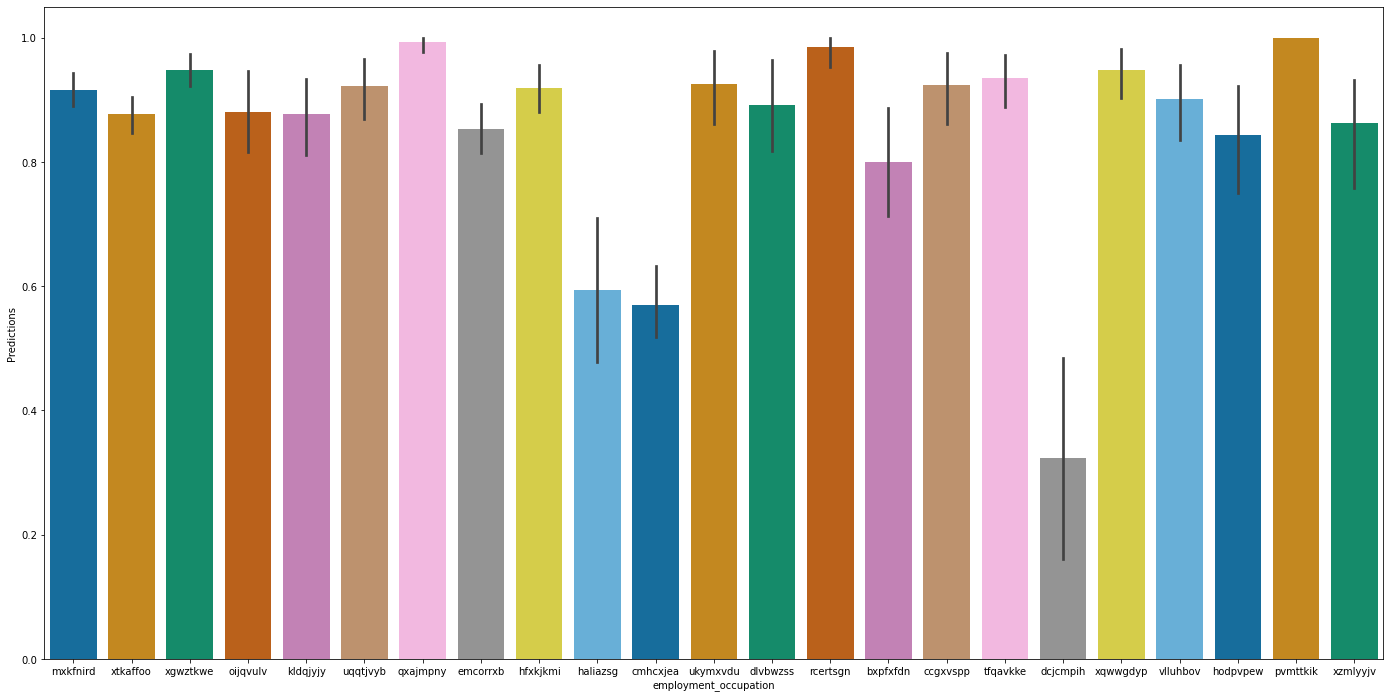

In [175]:
explore('employment_occupation')
#coded in random strings for privacy purposes

               Predictions
health_worker             
0.0               0.895729
1.0               0.640466


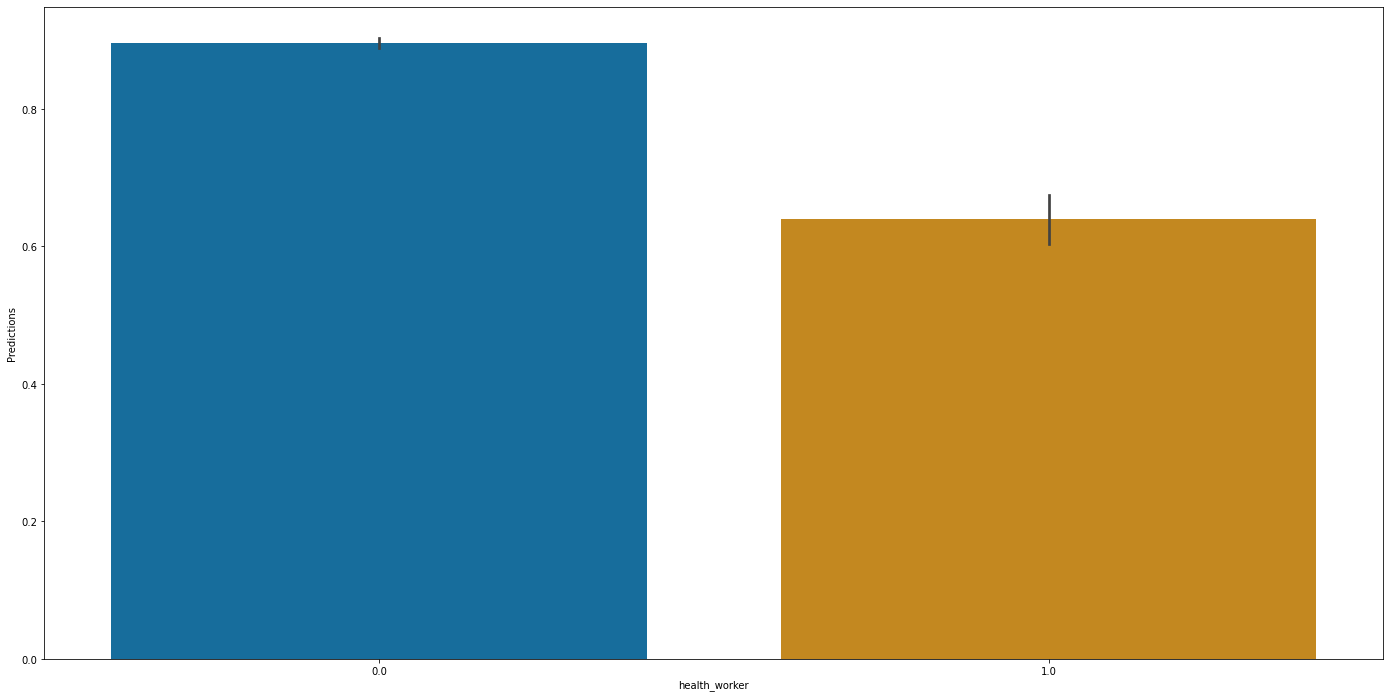

In [176]:
explore('health_worker')

                  Predictions
health_insurance             
0.0                  0.938190
1.0                  0.832234


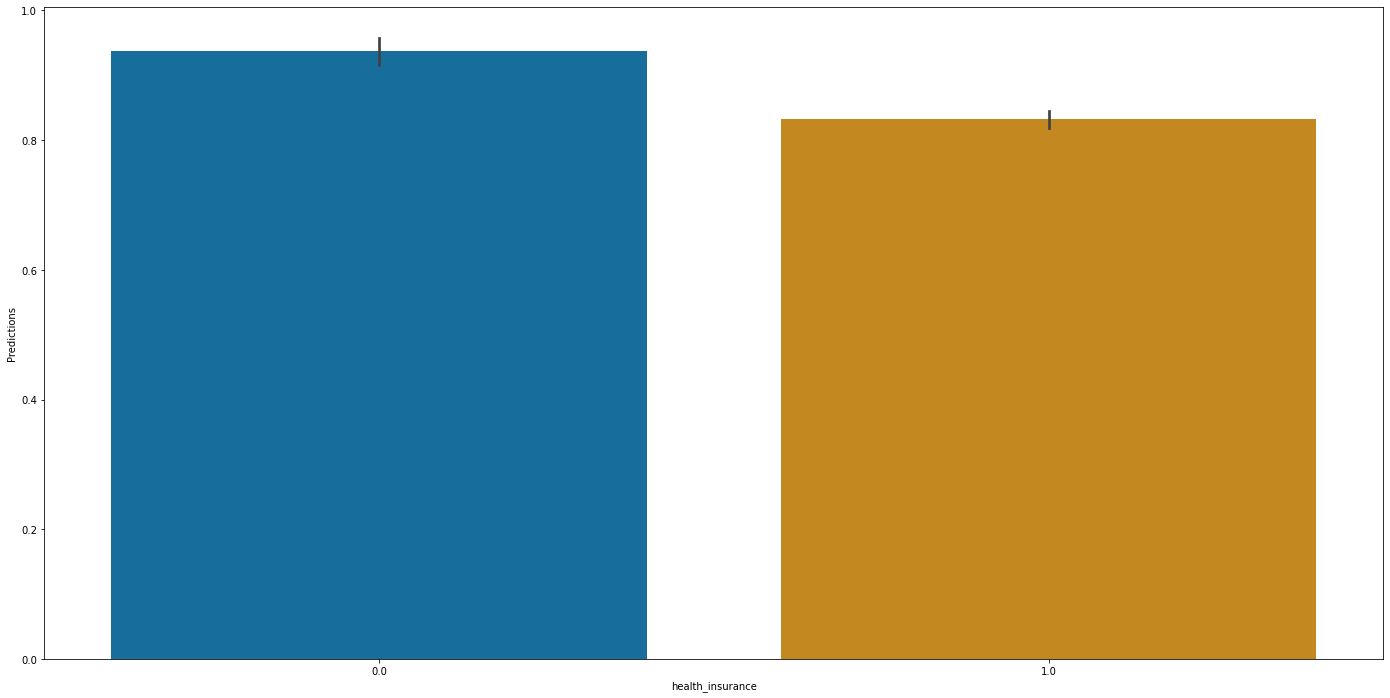

In [177]:
explore('health_insurance')

Exporting X_preds DataFrame to use in creating Tableau visualizations.

In [130]:
#X_preds.to_csv('h1n1vaccines.csv')

Let's move to Tableau to create our visualizations. 
Tableau dashboard linked here:
https://public.tableau.com/app/profile/kendall.mcneil/vizzes